<a href="https://colab.research.google.com/github/junhan-kim/deeplearning/blob/master/DL_HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

텐서플로우 홈페이지에서 참고하였습니다.
https://www.tensorflow.org/beta/tutorials/generative/dcgan

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [15]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images[0])
train_images = (train_images - 127.5) / 127.5 # 0 ~ 255 값을 -1 ~ 1 값으로 정규화합니다

[[[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [  0.]
  [ 

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
# 업스케일링하여 이미지 생성
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))  # Latent Vector  to 7 x 7 x 256 크기의 1차원 벡터
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # leakyReLU 사용

    model.add(layers.Reshape((7, 7, 256)))  # 7 x 7 x 256의 3차원 벡터로 변환
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))  # Conv2DTranspose = DeConv2D (업스케일링)
    assert model.output_shape == (None, 7, 7, 128)  # 7 x 7 x 128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)  # 14 x 14 x 64
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)   # 28 x 28 x 1 의 이미지로 output

    return model

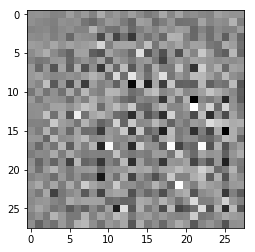

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)   # Latent Vector = noise

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',    # 28 x 28 x 1의 실제 이미지
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))  # 다운 스케일링
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # 1로 출력

    return model

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00092172]], shape=(1, 1), dtype=float32)


In [0]:
# 크로스엔트로피로 loss 산출하기 위한 헬퍼 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 실제 이미지와 같은 크기의 1행렬 비교하여 loss구함 => 진짜를 검출해내지 못한 loss
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 가짜 이미지와 0행렬 비교 => 가짜를 걸러내지 못한 loss
    total_loss = real_loss + fake_loss
    return total_loss  # 전체 loss

In [0]:
def generator_loss(fake_output):  
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 가짜 이미지와 1행렬 비교 => 가짜를 진짜로 속이지 못한 loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)   # 아담, lr = 0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)   # 진짜 이미지를 넣어서 1 
      fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 넣어서 0

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)  # 각 loss 산출

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)   # loss를 통해 gradient 산출

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # gradient로 optimizing

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:  # 학습 실행
      train_step(image_batch)

    # 이미지 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

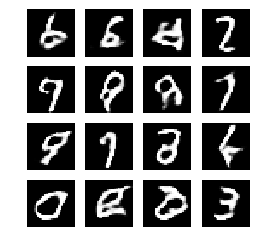

CPU times: user 2min 32s, sys: 35.1 s, total: 3min 7s
Wall time: 9min 40s


In [30]:
%%time
train(train_dataset, EPOCHS)  # 학습

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

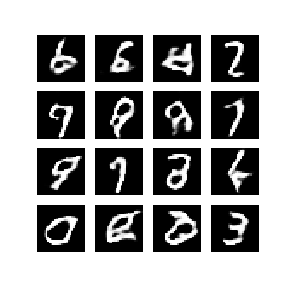

In [33]:
display_image(EPOCHS) # 최종 이미지

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)